In [ ]:
# query_list = ['./data/oxford5k_images/hertford_000056.jpg', './data/oxford5k_images/hertford_000056.jpg']
#!pip install h5py
#!pip install scipy
#!pip install scikit-image
#sudo apt-get install libglib2.0-0
#!apt-get -y install libglib2.0-0
#!apt-get install -y libsm6 libxext6 libxrender-dev

In [1]:
import os, sys, time
sys.path.append('../')
sys.path.append('../train')
sys.path.append('../helper')
from PIL import Image
from io import BytesIO
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from train.delf import Delf_V1
from feeder import Feeder
import matcher

def resize_image(image, target_size=800):
    def calc_by_ratio(a, b):
        return int(a * target_size / float(b))

    size = image.size
    if size[0] < size[1]:
        w = calc_by_ratio(size[0], size[1])
        h = target_size
    else:
        w = target_size
        h = calc_by_ratio(size[1], size[0])

    image = image.resize((w, h), Image.BILINEAR)
    return image


def get_and_cache_image(image_path, basewidth=None):
    image = Image.open(image_path)
    if basewidth is not None:
        image = resize_image(image, basewidth)
    imgByteArr = BytesIO()
    image.save(imgByteArr, format='PNG')
    imgByteArr = imgByteArr.getvalue()
    return image, imgByteArr


def get_result(feeder, query):
    pil_image = []
    byte_image = []
    for _, v in enumerate(query):
        pil, byte = get_and_cache_image(v)
        pil_image.append(pil)
        byte_image.append(byte)

    # feed and get output.
    outputs = feeder.feed_to_compare(query, pil_image)
    print('# of extracted feature (qeuery):', len(outputs[0]['descriptor_np_list']))
    print('# of extracted feature (db):', len(outputs[0]['descriptor_np_list']))
    
    att1 = matcher.get_attention_image_byte(outputs[0]['attention_np_list'])
    att2 = matcher.get_attention_image_byte(outputs[1]['attention_np_list'])

    side_by_side_comp_img_byte, score = matcher.get_ransac_image_byte(
        byte_image[0],
        outputs[0]['location_np_list'],
        outputs[0]['descriptor_np_list'],
        byte_image[1],
        outputs[1]['location_np_list'],
        outputs[1]['descriptor_np_list'])
    print('matching inliner num:', score)
    return side_by_side_comp_img_byte, att1, att2

In [2]:
import numpy as np
from matplotlib.pyplot import imshow

feeder_config = {
    'GPU_ID': 0,
    'IOU_THRES': 0.98,
    'ATTN_THRES': 0.37,
    'TARGET_LAYER': 'layer3',
    'TOP_K': 1000,
    #'PCA_PARAMETERS_PATH':'./output/pca/banknote_v3_hana_balanced/pca.h5',
    'PCA_PARAMETERS_PATH':'../pretrained_model/pca/pca.h5',
    #'PCA_PARAMETERS_PATH':'./output/pca/glr2k/pca.h5',
    'PCA_DIMS':40,
    'USE_PCA': True, #False,
    #'SCALE_LIST': [0.25, 0.3535, 0.5, 0.7071, 1.0, 1.4147, 2.0],
    'SCALE_LIST': [0.25, 0.3535, 0.5, 0.7071, 1.0, 1.4147], # Add high scale will either be too slow or lead to error
    
    #'LOAD_FROM': '../train/repo/banknote_v3_balanced_hana_alt/keypoint/ckpt/fix.pth.tar',
    #'LOAD_FROM': '../train/repo/ldmk/keypoint/ckpt/fix.pth.tar',
    'LOAD_FROM': '../pretrained_model/model/keypoint/ckpt/fix.pth.tar',
    'ARCH': 'resnet50',
    'EXPR': 'dummy',
    'TARGET_LAYER': 'layer3',
}
myfeeder = Feeder(feeder_config)


load DeLF pytorch model...
This is feeder.py/_build_delf_config
{'arch': 'resnet50', 'expr': 'dummy', 'load_from': '../pretrained_model/model/keypoint/ckpt/fix.pth.tar', 'ncls': 'dummy', 'stage': 'inference', 'target_layer': 'layer3', 'use_random_gamma_rescale': False}
[inference] loading resnet50 pretrained ImageNet weights ... It may take few seconds...
deep copied weights from layer "conv1" ...
deep copied weights from layer "bn1" ...
deep copied weights from layer "relu" ...
deep copied weights from layer "maxpool" ...
deep copied weights from layer "layer1" ...
deep copied weights from layer "layer2" ...
deep copied weights from layer "layer3" ...
loaded weights from module "base" ...
loaded weights from module "attn" ...
loaded weights from module "pool" ...
load model from "../pretrained_model/model/keypoint/ckpt/fix.pth.tar"
load PCA parameters...


../helper/feeder.py:72: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.pca_mean = h5file['.']['pca_mean'].value
../helper/feeder.py:73: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.pca_vars = h5file['.']['pca_vars'].value
../helper/feeder.py:74: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.pca_matrix = h5file['.']['pca_matrix'].value


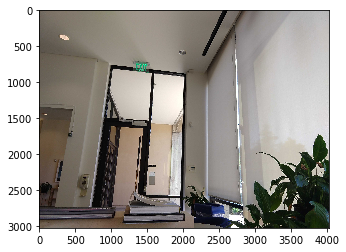

In [3]:
prefix = '../'
query = [prefix + '1_1.jpg', prefix + '1_2.jpg']
#plt.figure(figsize=(16,12))
img1 = mpimg.imread(query[0])
imgplot = plt.imshow(img1)
plt.show()

/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


----------------------------------------------------------
filename:  ../1_1.jpg
location_np_list shape:  (1000, 2)
descriptor_np_list shape:  (1000, 40)
feature_scale_np_list shape:  (1000,)
attention_score_np_list shape:  (1000,)
attention_np_list shape:  (1, 1, 189, 252)
----------------------------------------------------------
----------------------------------------------------------
filename:  ../1_2.jpg
location_np_list shape:  (1000, 2)
descriptor_np_list shape:  (1000, 40)
feature_scale_np_list shape:  (1000,)
attention_score_np_list shape:  (1000,)
attention_np_list shape:  (1, 1, 189, 252)
----------------------------------------------------------
# of extracted feature (qeuery): 1000
# of extracted feature (db): 1000
attn_score shape: (1, 1, 189, 252)
attn_score shape: (1, 1, 189, 252)
matching inliner num: 80


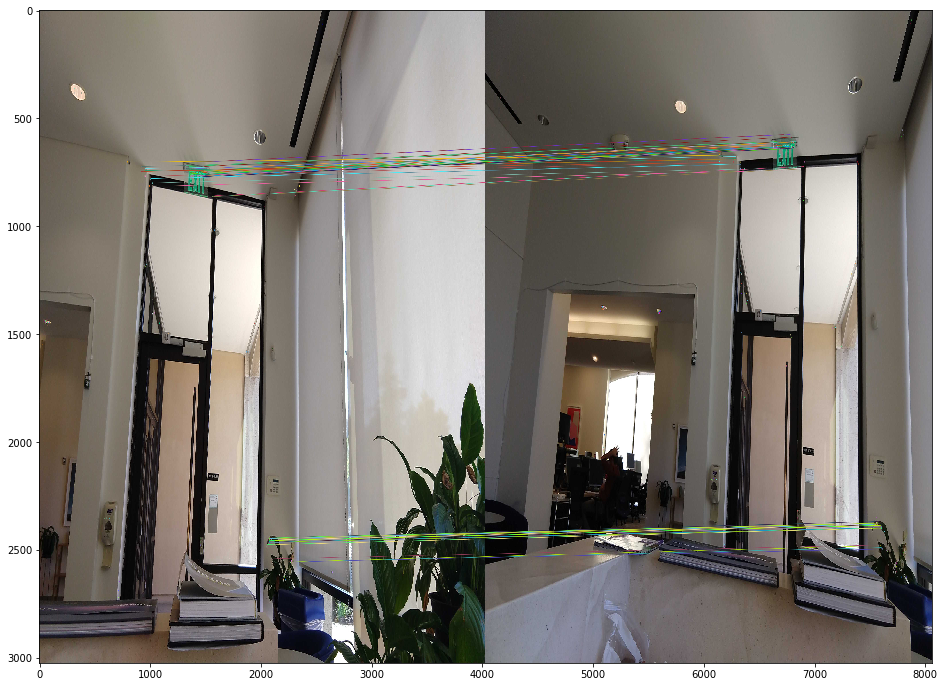

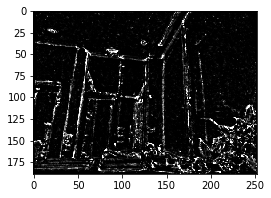

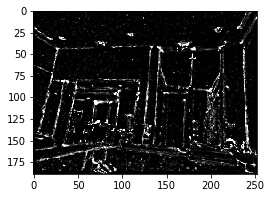

In [4]:
prefix = '../'
query = [prefix + '1_1.jpg', prefix + '1_2.jpg']
result_image_byte, att1, att2 = get_result(myfeeder, query)
plt.figure(figsize=(16,12))
result_image = Image.open(BytesIO(result_image_byte))
imshow(np.asarray(result_image), aspect='auto')
plt.figure(figsize=(4,3))
att1_image = Image.open(BytesIO(att1))
imshow(np.asarray(att1_image), aspect='auto')
plt.figure(figsize=(4,3))
att2_image = Image.open(BytesIO(att2))
imshow(np.asarray(att2_image), aspect='auto')

----------------------------------------------------------
filename:  ../3_1.jpg
location_np_list shape:  (1000, 2)
descriptor_np_list shape:  (1000, 40)
feature_scale_np_list shape:  (1000,)
attention_score_np_list shape:  (1000,)
attention_np_list shape:  (1, 1, 252, 189)
----------------------------------------------------------
----------------------------------------------------------
filename:  ../3_2.jpg
location_np_list shape:  (1000, 2)
descriptor_np_list shape:  (1000, 40)
feature_scale_np_list shape:  (1000,)
attention_score_np_list shape:  (1000,)
attention_np_list shape:  (1, 1, 252, 189)
----------------------------------------------------------
# of extracted feature (qeuery): 1000
# of extracted feature (db): 1000
attn_score shape: (1, 1, 252, 189)
attn_score shape: (1, 1, 252, 189)
matching inliner num: 16


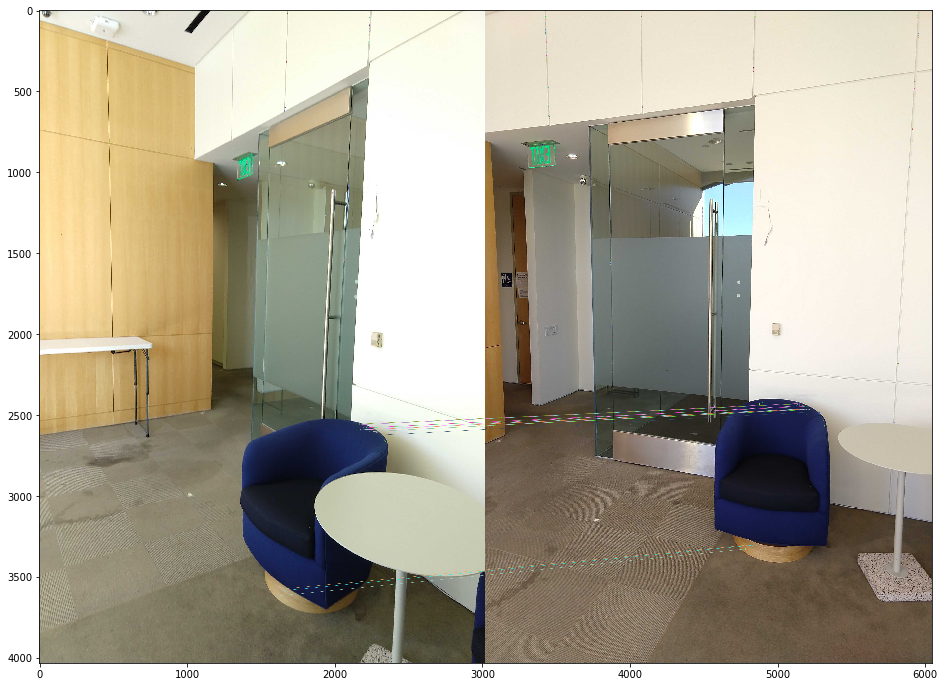

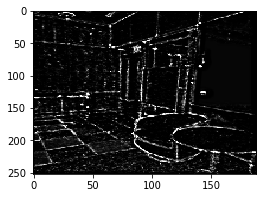

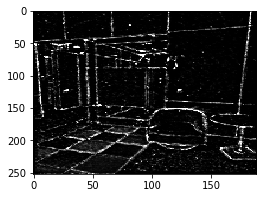

In [5]:
prefix = '../'
query = [prefix + '3_1.jpg', prefix + '3_2.jpg']
result_image_byte, att1, att2 = get_result(myfeeder, query)
plt.figure(figsize=(16,12))
result_image = Image.open(BytesIO(result_image_byte))
imshow(np.asarray(result_image), aspect='auto')
plt.figure(figsize=(4,3))
att1_image = Image.open(BytesIO(att1))
imshow(np.asarray(att1_image), aspect='auto')
plt.figure(figsize=(4,3))
att2_image = Image.open(BytesIO(att2))
imshow(np.asarray(att2_image), aspect='auto')

In [ ]:
prefix = '../'
query = [prefix + '2_1.jpg', prefix + '2_2.jpg']
result_image_byte, att1, att2 = get_result(myfeeder, query)
plt.figure(figsize=(16,12))
result_image = Image.open(BytesIO(result_image_byte))
imshow(np.asarray(result_image), aspect='auto')
plt.figure(figsize=(4,3))
att1_image = Image.open(BytesIO(att1))
imshow(np.asarray(att1_image), aspect='auto')
plt.figure(figsize=(4,3))
att2_image = Image.open(BytesIO(att2))
imshow(np.asarray(att2_image), aspect='auto')

----------------------------------------------------------
filename:  ../2_1.jpg
location_np_list shape:  (1000, 2)
descriptor_np_list shape:  (1000, 40)
feature_scale_np_list shape:  (1000,)
attention_score_np_list shape:  (1000,)
attention_np_list shape:  (1, 1, 68, 120)
----------------------------------------------------------
